In [1]:
import pandas as pd
import re
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('amazon-meta.txt') as f:
    data = f.read().split('\n\n')

In [4]:
data[2].split('\n')

['Id:   1',
 'ASIN: 0827229534',
 '  title: Patterns of Preaching: A Sermon Sampler',
 '  group: Book',
 '  salesrank: 396585',
 '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 '  categories: 2',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '  reviews: total: 2  downloaded: 2  avg rating: 5',
 '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
 '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5']

### Edit data from text into dictionary form

In [5]:
def get_dict(lines):
    dic = {}
    review = False
    cat = False
    for it in range(len(lines)):
        line = lines[it]
        item = line.strip().split(':')
        
        key = item[0]
        if it < 7:
            dic[key] = ':'.join(item[1:]).strip()
        
        if review == True:
            date = re.findall(r"\d+-\d+-\d+", line)
            re_list = get_dict(re.findall(r"\w+:\s+\S+", line))
            re_list['date'] = date[0]
            dic['reviewer'].append(re_list)
            
        if key == 'reviews':
            cat = False
            review = True
            dic[key] = get_dict(re.findall(r"\w+:\s+\S+",':'.join(item[1:]).strip()))
            dic['reviewer'] = []
    
        if cat == True:
            key = key.strip()
            dic['cat'].append({'category': key})
        
        if key == 'categories':
            cat = True
            dic['cat'] = []
            
    return dic
            
get_dict(data[2].split('\n'))

{'ASIN': '0827229534',
 'Id': '1',
 'cat': [{'category': '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'},
  {'category': '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]'}],
 'categories': '2',
 'group': 'Book',
 'reviewer': [{'cutomer': 'A2JW67OY8U6HHK',
   'date': '2000-7-28',
   'helpful': '9',
   'rating': '5',
   'votes': '10'},
  {'cutomer': 'A2VE83MZF98ITY',
   'date': '2003-12-14',
   'helpful': '5',
   'rating': '5',
   'votes': '6'}],
 'reviews': {'downloaded': '2', 'rating': '5', 'total': '2'},
 'salesrank': '396585',
 'similar': '5  0804215715  156101074X  0687023955  0687074231  082721619X',
 'title': 'Patterns of Preaching: A Sermon Sampler'}

In [6]:
len(data)

548554

### There is memory issue on my laptop(not enough RAM), so I can only work on a part of the data.

In [7]:
dict_pre = [get_dict(l.split('\n')) for l in data[:200000] if len(l.split('\n')) > 8]

In [9]:
dict_pre[2].keys()

dict_keys(['Id', 'ASIN', 'title', 'group', 'salesrank', 'similar', 'categories', 'cat', 'reviews', 'reviewer'])

In [11]:
data_all = json_normalize(dict_pre, 'reviewer', ['Id','ASIN','title','group','categories','salesrank','similar',['reviews','total']])

In [12]:
data_all.helpful = data_all.helpful.astype(int)
data_all.rating = data_all.rating.astype(int)
data_all.votes = data_all.votes.astype(int)
data_all.Id = data_all.Id.astype(int)
data_all.categories = data_all.categories.astype(int)
data_all.salesrank = data_all.salesrank.astype(int)
data_all = data_all.rename(columns = {'reviews.total':'reviews_total'})
data_all.reviews_total = data_all.reviews_total.astype(int)

In [13]:
data_all.head()

,cutomer,date,helpful,rating,votes,Id,ASIN,title,group,categories,salesrank,similar,reviews_total
0,A2JW67OY8U6HHK,2000-7-28,9,5,10,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,2,396585,5 0804215715 156101074X 0687023955 0687074...,2
1,A2VE83MZF98ITY,2003-12-14,5,5,6,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,2,396585,5 0804215715 156101074X 0687023955 0687074...,2
2,A11NCO6YTE4BTJ,2001-12-16,4,5,5,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 0738700...,12
3,A9CQ3PLRNIR83,2002-1-7,5,4,5,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 0738700...,12
4,A13SG9ACZ9O5IM,2002-1-24,8,5,8,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 0738700...,12


In [14]:
avg_rating = data_all.groupby('Id')[['rating','salesrank']].mean()
avg_rating.head()

,rating,salesrank
Id,,
1,5.000000,396585.0
2,4.333333,168596.0
3,5.000000,1270652.0
4,4.000000,631289.0
6,4.235294,188784.0


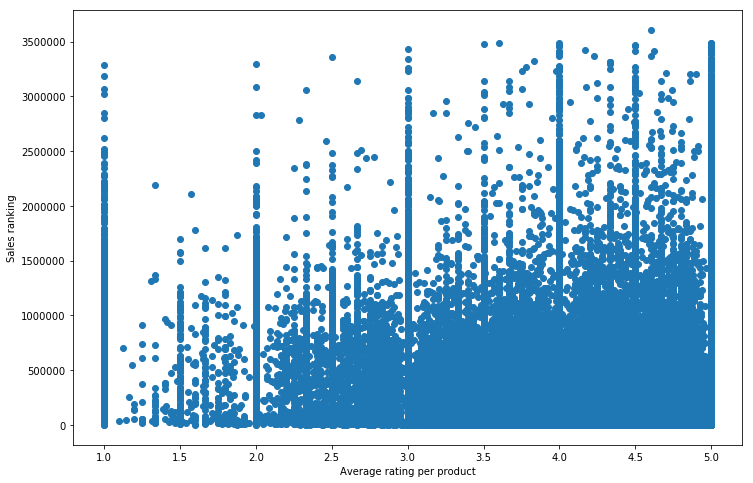

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(avg_rating.rating, avg_rating.salesrank)
plt.xlabel('Average rating per product')
plt.ylabel('Sales ranking')
plt.show()

In [16]:
avg_rating.corr()

,rating,salesrank
rating,1.000000,-0.015558
salesrank,-0.015558,1.000000


### There is a weak correlation between rating and salesrank. And there are large numbers of low rating products with high sales ranking. So the rating is not worth to trust.

In [17]:
dic_cat = json_normalize(dict_pre, 'cat', ['ASIN','group','categories'])
dic_cat.head()

,category,ASIN,group,categories
0,|Books[283155]|Subjects[1000]|Religion & Spiri...,0827229534,Book,2
1,|Books[283155]|Subjects[1000]|Religion & Spiri...,0827229534,Book,2
2,|Books[283155]|Subjects[1000]|Religion & Spiri...,0738700797,Book,2
3,|Books[283155]|Subjects[1000]|Religion & Spiri...,0738700797,Book,2
4,|Books[283155]|Subjects[1000]|Home & Garden[48...,0486287785,Book,1


In [18]:
book_data = dic_cat[dic_cat.group == 'Book']
print('Total products',len(book_data.ASIN.unique()))
print('Total categories', len(book_data.category.unique()))
print('Categories in total products {:.2f}{}'.format(len(book_data.ASIN.unique())/len(book_data.category.unique()),'%'))

Total products 136353
Total categories 11528
Categories in total products 11.83%


### The number of categories are over 11% of the total products, which means redundant categories can be removed. (But the data may not accurate, due to the imcomplete data set.)

In [19]:
all_category = book_data.category.apply(lambda x: re.findall('[a-zA-Z]+',x))
all_category.head()

0    [Books, Subjects, Religion, Spirituality, Chri...
1    [Books, Subjects, Religion, Spirituality, Chri...
2    [Books, Subjects, Religion, Spirituality, Eart...
3    [Books, Subjects, Religion, Spirituality, Eart...
4    [Books, Subjects, Home, Garden, Crafts, Hobbie...
Name: category, dtype: object

In [20]:
L = all_category.as_matrix()
catNames = [item for sublist in L for item in sublist]
n_catNames = len(set(catNames))
print("Number of unique category names:" , n_catNames)

Number of unique category names: 7388


In [21]:
new_category =pd.DataFrame({'Original': all_category.apply(lambda x: '_'.join(x)),
                        'Level_1': all_category.apply(lambda x: x[-1]),
                        'Level_2': all_category.apply(lambda x: x[-2]),
                        'Level_no1': all_category.apply(lambda x: '_'.join(x[:-1])),
                        'Level_no2': all_category.apply(lambda x: '_'.join(x[:-2]))
                       }, dtype = str) 
new_category.head()

,Level_1,Level_2,Level_no1,Level_no2,Original
0,Preaching,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
1,Sermons,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
2,Wicca,Religions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth_Based,Books_Subjects_Religion_Spirituality_Earth_Bas...
3,Witchcraft,Religions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth_Based,Books_Subjects_Religion_Spirituality_Earth_Bas...
4,General,Hobbies,Books_Subjects_Home_Garden_Crafts_Hobbies,Books_Subjects_Home_Garden_Crafts,Books_Subjects_Home_Garden_Crafts_Hobbies_General


In [22]:
size_rest = new_category.drop_duplicates(subset='Original').groupby('Level_no1').size().sort_values(ascending = False)
size_rest

Level_no1
Books_Subjects_Reference_Dictionaries_Thesauruses_Foreign_Language                                  48
Books_Subjects_Home_Garden_Crafts_Hobbies                                                           36
Books_Subjects_History_Europe                                                                       34
Books_Formats_Sheet_Music_Scores_Composers                                                          28
Books_Subjects_History_Africa                                                                       26
Books_Subjects_Home_Garden_Antiques_Collectibles                                                    25
Books_Subjects_Reference_Foreign_Languages_Instruction                                              23
Books_Subjects_History_Asia                                                                         22
Books_Subjects_Religion_Spirituality_Christianity_Theology                                          19
Books_Subjects_Health_Mind_Body_Disorders_Diseases             

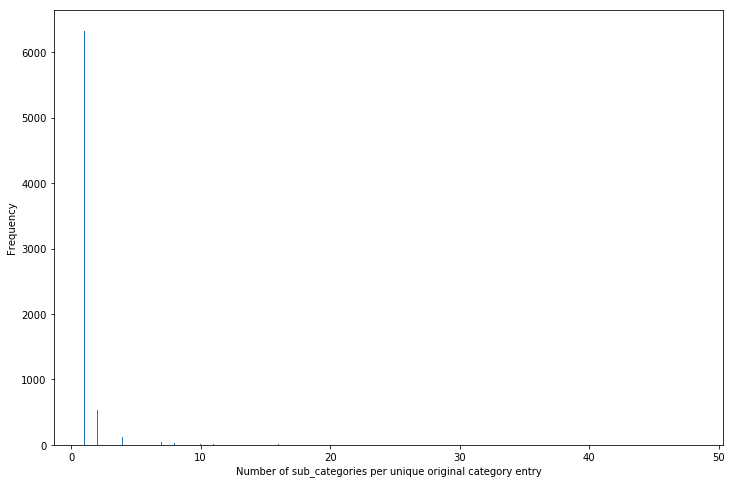

In [23]:
plt.figure(figsize=(12,8))
plt.hist(size_rest, 1000) # set 1000 bins
plt.xlabel('Number of sub_categories per unique original category entry')
plt.ylabel('Frequency')
plt.show()

In [24]:
n_original = len(new_category.Original.unique())
print('The number of categories with one sub-category:',sum(size_rest<2))
print('\nThe original unique category entries:' , n_original)
print('\nPortion of categories can be removed:', sum(size_rest<2)/n_original)

The number of categories with one sub-category: 6328

The original unique category entries: 11470

Portion of categories can be removed: 0.551700087184


### 55% can be removed, and the number of unique category entries remain the same.

In [25]:
size_rest_sub = new_category.loc[new_category.Level_no1.isin(size_rest.index.values[size_rest==1]), :].groupby('Level_no2').size().sort_values(ascending = False)
size_rest_sub

C:\Users\Chiroy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


Level_no2
Books_Subjects_Home_Garden_Crafts                            3322
Books_Subjects_Reference_Dictionaries_Thesauruses_Foreign     836
dtype: int64

In [26]:
print('The number of categories with one sub-category in the last two layers:',sum(size_rest_sub == 1))

The number of categories with one sub-category in the last two layers: 0


#### (I supposed it could be removed if the data set is completed. But this number is 0 here.)

In [27]:
print('The number of categories with two sub-category:',sum(size_rest == 2))

The number of categories with two sub-category: 534


In [28]:
print('\nPortion of categories can be removed:', sum(size_rest == 2)/n_original)


Portion of categories can be removed: 0.046556233653


In [29]:
print('The number of categories with two sub-category second to last category:',sum(size_rest_sub == 2))

The number of categories with two sub-category second to last category: 0


#### (Again, it could be removed if the dataset is complete.)

In [30]:
print('The number of categories with three sub-category :',sum(size_rest == 3))

The number of categories with three sub-category : 317


In [31]:
print('\nPortion of categories can be removed:', sum(size_rest == 3)/n_original)


Portion of categories can be removed: 0.0276373147341


#### So there is 0.55+0.046+0.028 = 62% (at least) of unique category names can be removed. If we remove them, the number of unique category entries remain the same.
#### The number of unique category entries reduces by 534+317 = 851 (7.4%) in this way.

### Product Thinking
<br>a. No, I don't think the users would care about the categorization hieracrchy while they are shopping.<br/>
<br>b. Yes. That would be easier for users to compare different products.<br/>
<br>c. Yes. Although some reviews are not trustworthiness, but it still could help users making their decisions after reviewing some other comments.<br/>
<br>d. We could build A/B tests for each above.<br/>